M=200, N=20, k=2 파라미터로 클러스터링-인기도 기반 동적 그래프를 생성합니다.


Power-Law(gamma=3) 분포 기반으로 엣지 상태 재할당 완료!
cluster edges [(0, 2), (0, 4), (0, 6), (0, 8), (0, 12), (0, 14), (0, 16), (0, 18), (0, 36), (0, 40), (0, 44), (0, 46), (0, 50), (0, 52), (0, 58), (0, 62), (0, 64), (0, 66), (0, 80), (0, 90), (0, 92), (0, 136), (0, 144), (0, 178), (0, 180), (2, 8), (2, 14), (2, 20), (2, 24), (2, 26), (2, 28), (2, 32), (2, 34), (2, 38), (2, 42), (2, 44), (2, 54), (2, 78), (2, 86), (2, 104), (2, 108), (2, 118), (2, 126), (2, 148), (2, 150), (2, 154), (2, 164), (1, 3), (1, 4), (1, 5), (1, 11), (1, 17), (1, 27), (1, 29), (1, 33), (1, 35), (1, 51), (1, 69), (1, 77), (1, 97), (1, 131), (1, 143), (1, 151), (3, 5), (3, 7), (3, 9), (3, 43), (4, 6), (4, 10), (4, 20), (4, 24), (4, 30), (4, 62), (4, 76), (4, 100), (4, 102), (4, 106), (4, 124), (4, 142), (4, 182), (5, 7), (5, 9), (5, 13), (5, 15), (5, 21), (5, 41), (5, 43), (5, 47), (5, 53), (5, 63), (5, 75), (5, 105), (5, 111), (5, 115), (5, 129), (5, 141), (5, 147), (5, 1

/tmp/ipykernel_236735/3953025133.py:198: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = plt.cm.get_cmap('plasma', N)


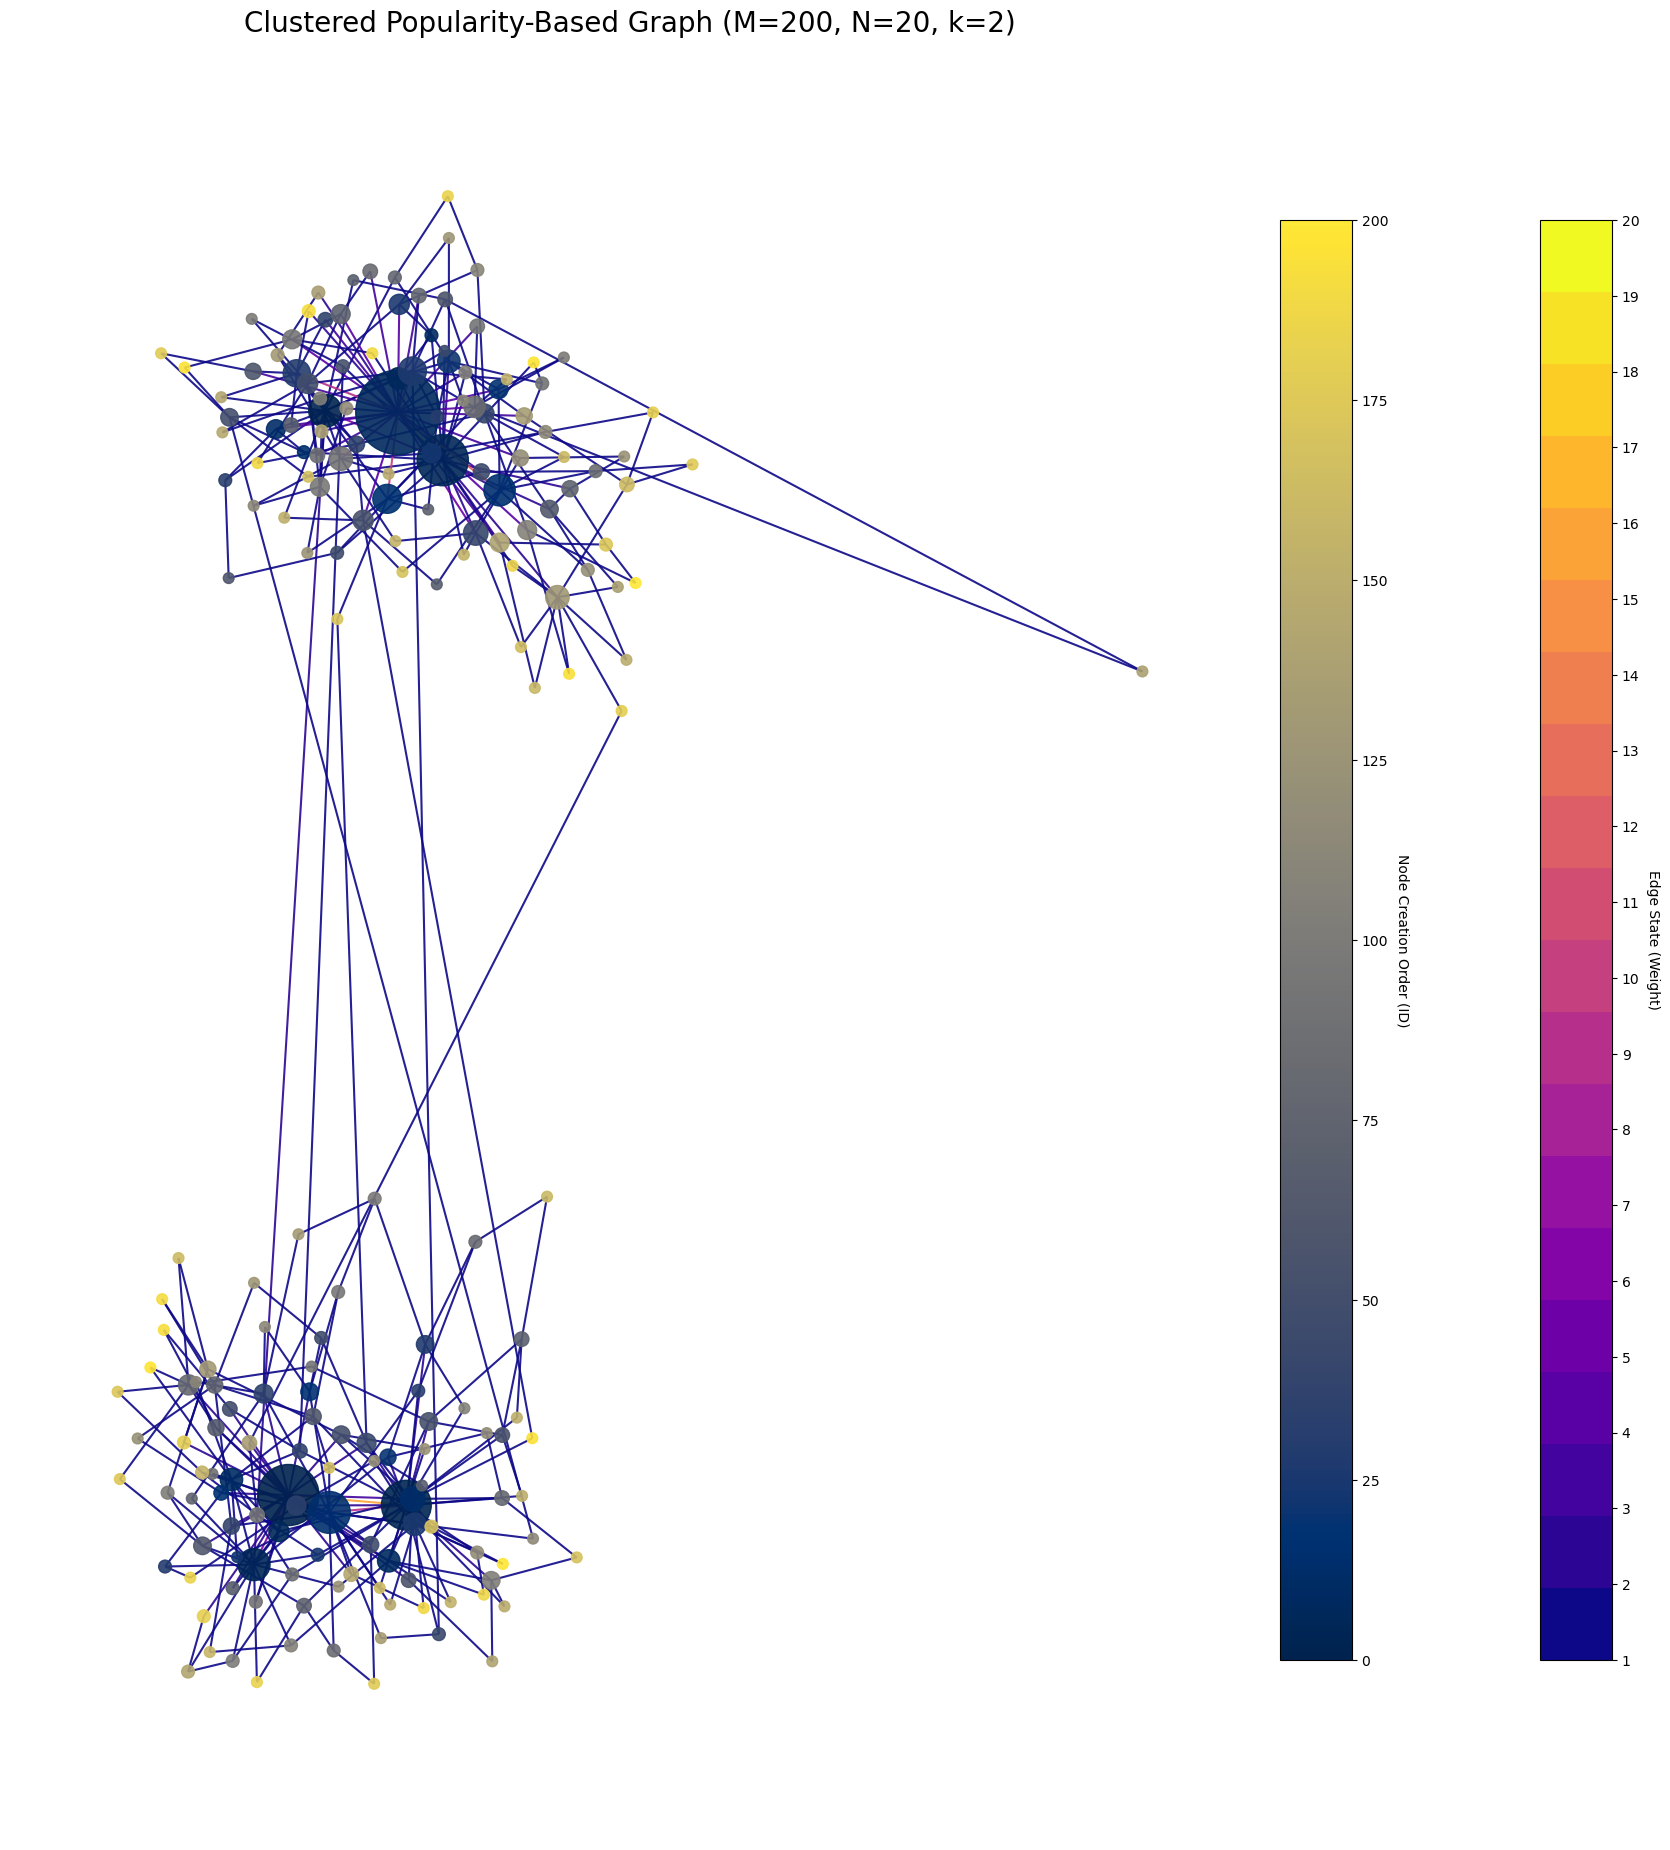

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import collections
import warnings

# Matplotlib 관련 경고 메시지를 무시합니다.
warnings.filterwarnings("ignore", category=UserWarning)

def calculate_intra_cluster_degree(G, cluster_map):
    """
    각 노드의 클러스터 내부 연결 degree만 계산
    """
    intra_cluster_degrees = {}
    
    for node in G.nodes():
        node_cluster = cluster_map[node]
        intra_degree = 0
        
        for neighbor in G.neighbors(node):
            neighbor_cluster = cluster_map[neighbor]
            if node_cluster == neighbor_cluster:  # 같은 클러스터 내의 연결만 카운트
                intra_degree += 1
        
        intra_cluster_degrees[node] = intra_degree
    
    return intra_cluster_degrees

def calculate_popularity(G):
    """
    인기도 = 해당 노드에 연결된 모든 엣지의 상태(state)의 합
    """
    popularity = {}
    for node in G.nodes():
        degree = G.degree(node)
        weighted_sum = sum(G.edges[node, neighbor]['state'] for neighbor in G.neighbors(node))
        popularity[node] = weighted_sum
    return popularity

def assign_edge_states_powerlaw(G, N, gamma=1):
    """
    그래프의 엣지 상태를 Power-Law 분포를 따르도록 할당합니다.
    인기도가 높은 엣지가 높은 상태 값을 갖도록 순위를 매겨 매핑합니다.

    Args:
        G (nx.Graph): 그래프 객체
        N (int): 최대 상태 값
        gamma (float): Power-Law 분포의 지수 (클수록 낮은 state에 더 집중됨)
    """
    # 1. 최종 그래프의 인기도 계산
    final_popularity = calculate_popularity(G)
    
    edges = list(G.edges())
    if not edges:
        return

    # 2. 엣지별 인기도 점수 계산 및 정렬
    edge_scores = []
    for u, v in edges:
        score = final_popularity.get(u, 0) + final_popularity.get(v, 0)
        edge_scores.append(((u, v), score))
    
    # 인기도 점수가 높은 순으로 엣지 정렬
    sorted_edges = sorted(edge_scores, key=lambda item: item[1], reverse=True)
    
    # 3. Power-Law 분포에서 상태 값들을 샘플링
    num_edges = len(edges)
    # 각 상태(1~N)가 나올 확률 계산 (P(s) ∝ s^(-gamma))
    states_range = np.arange(1, N + 1, dtype=float)
    probabilities = states_range ** -gamma
    probabilities /= probabilities.sum() # 정규화
    
    # 위 확률에 따라 전체 엣지 수만큼 상태를 무작위로 뽑음
    sampled_states = np.random.choice(states_range, size=num_edges, p=probabilities)
    
    # 4. 샘플링된 상태를 높은 값 순으로 정렬
    sorted_states = sorted(sampled_states, reverse=True)
    
    # 5. 정렬된 엣지와 정렬된 상태를 순서대로 매핑
    state_dict = {edge_tuple: state for (edge_tuple, score), state in zip(sorted_edges, sorted_states)}
    
    nx.set_edge_attributes(G, state_dict, 'state')

    print(f"\nPower-Law(gamma={gamma}) 분포 기반으로 엣지 상태 재할당 완료!")



def generate_clustered_popularity_graph(M, N, k, initial_nodes=5, connections_per_step=3, 
                                        intra_cluster_multiplier=1.5, inter_cluster_multiplier=0.5):

    if M < initial_nodes or k > initial_nodes:
        raise ValueError("초기 노드 수는 전체 노드 수보다 작고, 클러스터 수보다 크거나 같아야 합니다.")

    G = nx.Graph()
    node_to_cluster_map = {}

    # 초기 그래프 및 클러스터 할당
    for i in range(initial_nodes):
        cluster_id = i % k
        node_to_cluster_map[i] = cluster_id

    # 초기 그래프 및 클러스터 할당
    for i in range(initial_nodes):
        for j in range(i + 1, initial_nodes):
            if node_to_cluster_map[i] == node_to_cluster_map[j]:
                G.add_edge(i, j, state=1)
            
    # 나머지 노드를 하나씩 추가
    for i in range(initial_nodes, M):
        new_node_cluster = i % k
        node_to_cluster_map[i] = new_node_cluster
        
        popularity = calculate_popularity(G)
        existing_nodes = list(popularity.keys())
        pop_values = np.array(list(popularity.values()), dtype=float)
        # 클러스터 소속에 따라 인기도 조정
        adjusted_pop_values = []
        for node_j in existing_nodes:
            base_pop = popularity.get(node_j, 0) # 기본 인기도 
            if node_to_cluster_map[node_j] == new_node_cluster:
                # 같은 클러스터면 가중치 부여
                adjusted_pop_values.append(base_pop * intra_cluster_multiplier)
            else:
                # 다른 클러스터면 페널티 부여
                adjusted_pop_values.append(base_pop * inter_cluster_multiplier)
        
        adjusted_pop_values = np.array(adjusted_pop_values, dtype=float)

        # 조정된 인기도를 기반으로 연결 확률 계산
        if adjusted_pop_values.sum() == 0:
            connection_probs = np.ones(len(existing_nodes)) / len(existing_nodes)
        else:
            connection_probs = adjusted_pop_values / adjusted_pop_values.sum()
        
        # 연결할 노드 선택 및 엣지 생성
        num_to_connect = min(connections_per_step, len(existing_nodes))
        target_nodes = np.random.choice(
            existing_nodes,
            size=num_to_connect,
            replace=False,
            p=connection_probs
        )

        
        for target_node in target_nodes:
            G.add_edge(i, target_node, state=1)

            
    return G, node_to_cluster_map



M = 200 # 전체 노드 수
N = 20  # 상태 종류 수
k = 2   # 클러스터 개수

print(f"M={M}, N={N}, k={k} 파라미터로 클러스터링-인기도 기반 동적 그래프를 생성합니다.\n")


clustered_graph, cluster_map = generate_clustered_popularity_graph(
    M, N, k, 
    initial_nodes=k*2,
    connections_per_step=2,
    intra_cluster_multiplier=5, 
    inter_cluster_multiplier=0.2
)

gamma = 3
assign_edge_states_powerlaw(clustered_graph, N, gamma)


# --- 시각화 로직 ---
for u, v in clustered_graph.edges():
    if cluster_map[u] == cluster_map[v]:
        clustered_graph.edges[u, v]['layout_weight'] = 50.0
    else:
        clustered_graph.edges[u, v]['layout_weight'] = 0.1

print('cluster edges', clustered_graph.edges())
print('cluster map', cluster_map)

plt.figure(figsize=(18, 18))
pos = nx.spring_layout(
    clustered_graph, 
    seed=42, 
    k=0.8, 
    iterations=100,
    weight='layout_weight'
)

node_order_colors = list(clustered_graph.nodes())

final_popularity = calculate_popularity(clustered_graph)
print('final_popularity', final_popularity)
node_sizes = [final_popularity.get(node, 1) * 25 + 10 for node in clustered_graph.nodes()]

edge_states = nx.get_edge_attributes(clustered_graph, 'state').values()
edge_cmap = plt.cm.get_cmap('plasma', N)

nx.draw(
    clustered_graph,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_order_colors,
    cmap=plt.cm.cividis, 
    edge_color=list(edge_states),
    edge_cmap=edge_cmap,
    width=1.5,
    alpha=0.9
)

plt.title(f"Clustered Popularity-Based Graph (M={M}, N={N}, k={k})", size=20)

sm_edge = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=1, vmax=N))
sm_edge.set_array([])
cbar_edge = plt.colorbar(sm_edge, ax=plt.gca(), ticks=np.arange(1, N + 1), shrink=0.8, pad=0.02)
cbar_edge.set_label('Edge State (Weight)', rotation=270, labelpad=15)

sm_node = plt.cm.ScalarMappable(cmap=plt.cm.cividis, norm=plt.Normalize(vmin=0, vmax=M))
sm_node.set_array([])
cbar_node = plt.colorbar(sm_node, ax=plt.gca(), shrink=0.8, pad=0.02)
cbar_node.set_label('Node Creation Order (ID)', rotation=270, labelpad=15)

plt.show()




100
100


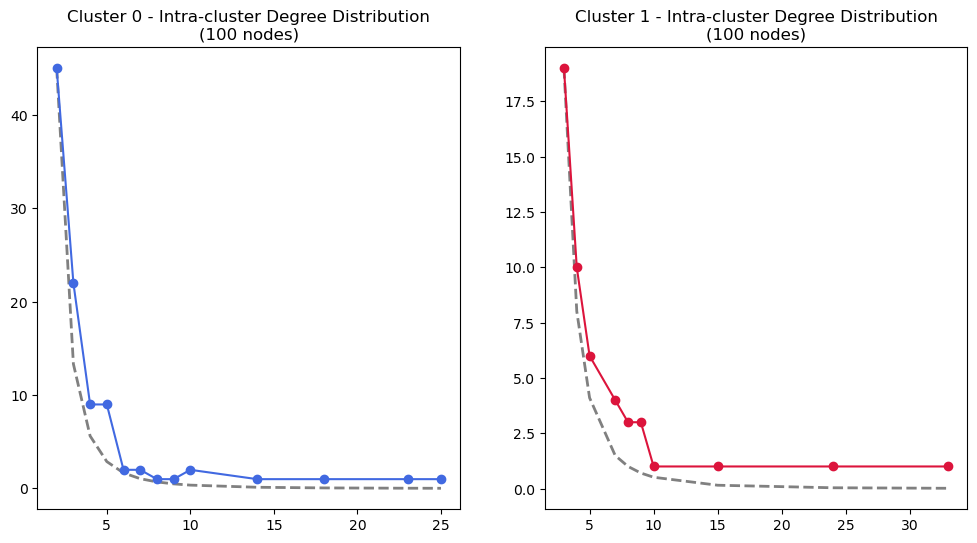

In [13]:
# --- Degree Distribution 시각화 ---

# 클러스터 내부 연결만으로 계산한 degree
intra_cluster_degrees = calculate_intra_cluster_degree(clustered_graph, cluster_map)

# 각 클러스터별로 노드들을 분류
clusters = {}
for node, cluster_id in cluster_map.items():
    if cluster_id not in clusters:
        clusters[cluster_id] = []
    clusters[cluster_id].append(node)

# 서브플롯 생성
fig, axes = plt.subplots(1, k, figsize=(6*k, 6))
if k == 1:
    axes = [axes]

colors = ['royalblue', 'crimson', 'green', 'orange', 'purple']

for cluster_id, cluster_nodes in clusters.items():
    ax = axes[cluster_id]
    
    # 해당 클러스터 노드들의 클러스터 내부 degree만 추출
    cluster_degrees = [intra_cluster_degrees[node] for node in cluster_nodes]
    print(len(cluster_degrees))
    # degree distribution 계산
    degree_counts = collections.Counter(cluster_degrees)
    
    if len(degree_counts) > 0:
        deg, cnt = zip(*sorted(degree_counts.items()))
        deg = deg[2:]  
        cnt = cnt[2:]
        
        color = colors[cluster_id % len(colors)]
        ax.plot(deg, cnt, 'o-', color=color, 
                label=f'Cluster {cluster_id} (Intra-cluster)', 
                markersize=6, zorder=2)
        
        # Reference line (power law with slope -3)
        if len(deg) > 1 and max(deg) > 0:
            C = cnt[0] * (deg[0] ** 3) if deg[0] > 0 else 1
            ref_y = C * (np.array(deg, dtype=float) ** -3)
            ax.plot(deg, ref_y, '--', color='gray', 
                    label='Reference line (slope = -3)', linewidth=2, zorder=1)
    
    ax.set_title(f"Cluster {cluster_id} - Intra-cluster Degree Distribution\n"
                f"({len(cluster_nodes)} nodes)")

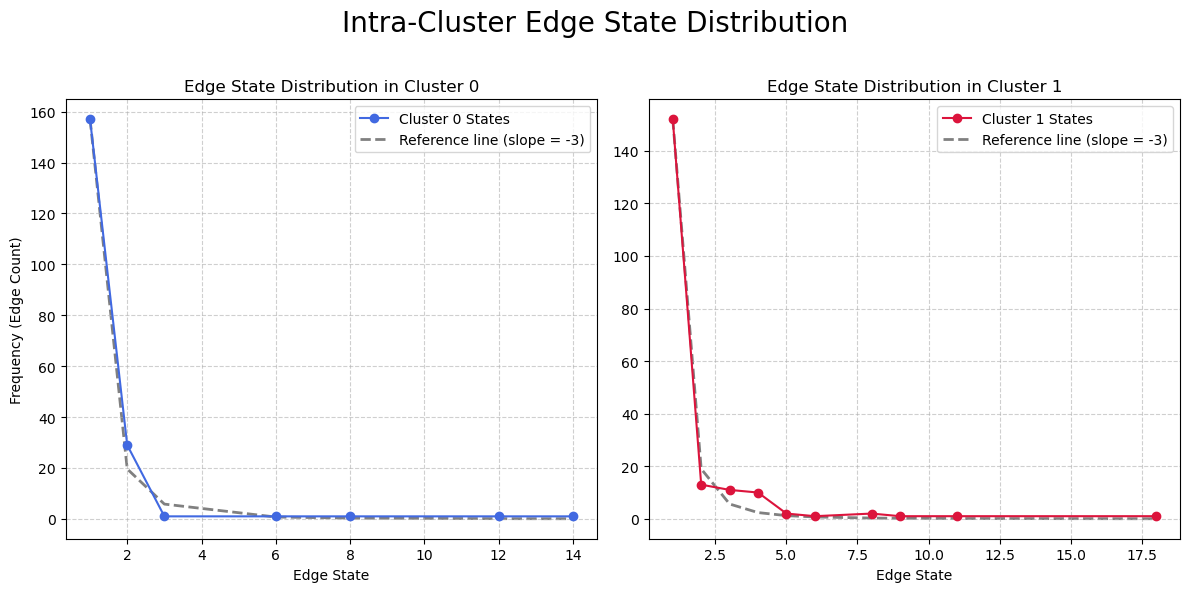

In [14]:
# --- (기존 코드는 생략) ---
# 기존 그래프 시각화 코드 바로 앞에 이 코드를 추가하세요.

# 1. 클러스터별로 내부 엣지의 'state' 값을 리스트에 저장 (이전과 동일)
cluster_edge_states = {}
for u, v, data in clustered_graph.edges(data=True):
    if cluster_map[u] == cluster_map[v]:
        cluster_id = cluster_map[u]
        state = data.get('state', 0)
        
        if cluster_id not in cluster_edge_states:
            cluster_edge_states[cluster_id] = []
        cluster_edge_states[cluster_id].append(state)

# ==============================================================================
# ✨ 요청 스타일을 적용한 시각화 로직
# ==============================================================================
fig, axes = plt.subplots(1, k, figsize=(6*k, 6))
if k == 1:
    axes = [axes]

colors = ['royalblue', 'crimson', 'green', 'orange', 'purple']

for cluster_id, state_list in sorted(cluster_edge_states.items()):
    ax = axes[cluster_id]
    color = colors[cluster_id % len(colors)]
    
    counts = collections.Counter(state_list)
    if not counts:
        ax.text(0.5, 0.5, 'No intra-cluster edges', ha='center', va='center')
        continue
        
    # deg, cnt 변수명을 사용하여 스타일 통일
    deg, cnt = zip(*sorted(counts.items()))
    
    # 요청하신 코드의 스타일을 그대로 재현
    ax.plot(deg, cnt, 'o-', color=color, 
            label=f'Cluster {cluster_id} States', 
            markersize=6, zorder=2)
    
    # Reference line (power law with slope -3)
    # 데이터 포인트가 2개 이상일 때만 참조선 그리기
    if len(deg) > 1:
        # deg[0]이 0인 경우를 대비하여 C값 안정화
        C = cnt[0] * (deg[0] ** 3) if deg[0] > 0 else (cnt[1] * (deg[1] ** 3) if len(deg) > 1 and deg[1] > 0 else 1)
        
        # 참조선 계산
        ref_y = C * (np.array(deg, dtype=float) ** -3)
        ax.plot(deg, ref_y, '--', color='gray', 
                label='Reference line (slope = -3)', linewidth=2, zorder=1)

    ax.set_title(f"Edge State Distribution in Cluster {cluster_id}")
    ax.set_xlabel("Edge State")
    if cluster_id == 0:
        ax.set_ylabel("Frequency (Edge Count)")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()


plt.suptitle("Intra-Cluster Edge State Distribution", size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 이어서 기존의 전체 그래프 시각화 코드가 실행됩니다.
# ...

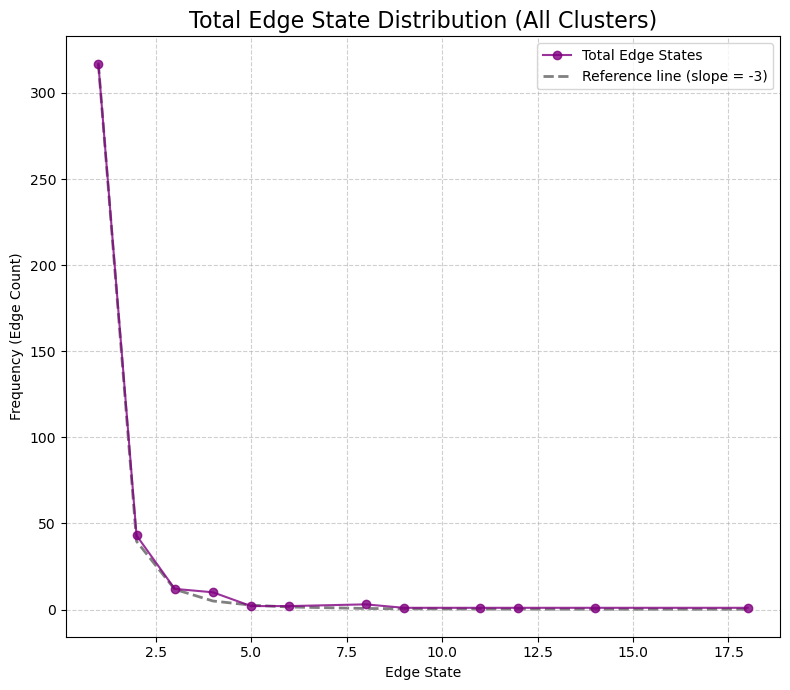

In [15]:
# 1. 전체 그래프의 모든 엣지 'state' 값을 하나의 리스트에 저장
all_edge_states = [data.get('state', 0) for u, v, data in clustered_graph.edges(data=True)]

# 2. 전체 엣지 상태의 분포 계산
total_counts = collections.Counter(all_edge_states)

if total_counts:
    # --- 전체 분포 시각화 (요청 스타일) ---
    fig, ax = plt.subplots(figsize=(8, 7))

    deg, cnt = zip(*sorted(total_counts.items()))

    # 데이터 플롯 (점과 선 연결)
    ax.plot(deg, cnt, 'o-', color='purple', alpha=0.8, label='Total Edge States')

    # Reference line (power law with slope -3)
    if len(deg) > 1:
        # deg가 0인 경우 처리
        first_valid_index = 0
        while first_valid_index < len(deg) and deg [first_valid_index] == 0:
            first_valid_index += 1

        if first_valid_index < len(deg):
            C = cnt [first_valid_index] * (deg [first_valid_index] ** 3) if deg [first_valid_index] > 0 else 1
            ref_y = C * (np.array(deg, dtype=float) ** -3)
            ax.plot(deg, ref_y, '--', color='gray', label='Reference line (slope = -3)', linewidth=2, zorder=1)

    ax.set_title("Total Edge State Distribution (All Clusters)", size=16)
    ax.set_xlabel("Edge State")
    ax.set_ylabel("Frequency (Edge Count)")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

    plt.tight_layout()
    plt.show()

# 이어서 기존의 전체 그래프 시각화 코드가 실행됩니다.
# ...

In [67]:
from networkx.algorithms.community import modularity

communities = [set() for _ in range(k)]
for node, cluster_id in cluster_map.items():
    communities[cluster_id].add(node)

mod = modularity(clustered_graph, communities)
print(f"모듈성 (Modularity): {mod:.4f}")
print(mod >= 0.35)

모듈성 (Modularity): 0.4847
True


In [62]:
state_weights = np.arange(1, 10, dtype=float) + 10 * 0.5 * 0.1
state_weights

array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

In [43]:
adj_matrix = nx.to_numpy_array(clustered_graph)

print("--- 기본 인접 행렬 (Adjacency Matrix) ---")
print(adj_matrix)
print(f"\n행렬 크기: {adj_matrix.shape}")


print("--- 인접 리스트 ---")


--- 기본 인접 행렬 (Adjacency Matrix) ---
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

행렬 크기: (100, 100)
--- 인접 리스트 ---


In [56]:
weighted_adj_matrix = nx.to_numpy_array(clustered_graph, weight='state', dtype=int)

print("--- 'state' 값을 이용한 가중치 인접 행렬 ---")
for i in weighted_adj_matrix:
    for j in i:
        print(j, end=' ')
    print()
print(f"\n행렬 크기: {weighted_adj_matrix.shape}")

--- 'state' 값을 이용한 가중치 인접 행렬 ---
0 17 0 0 0 0 0 0 12 14 0 0 7 0 0 0 0 0 0 0 0 0 0 0 13 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 7 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
17 0 0 0 0 0 0 0 16 0 0 0 12 0 0 0 12 0 0 0 16 0 0 0 0 0 0 12 0 0 0 0 13 0 0 0 0 0 0 0 11 0 0 0 14 0 0 0 0 0 0 0 0 0 0 0 11 0 0 0 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 12 0 0 0 0 0 0 0 0 0 0 0 0 0 11 0 11 0 0 0 0 0 0 0 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 0 0 0 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 0 0 0 0 0 0 0 10 0 0 0 10 0 0 0 
0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### 데이터셋 생성

In [8]:
def create_adjacency_matrix_dataset(num_samples, M, N, k, filename, **kwargs):
    dataset = []
    print(f"데이터셋 생성을 시작합니다. (총 {num_samples}개)")

    for i in range(num_samples):
        graph, _ = generate_clustered_popularity_graph(M, N, k, **kwargs)
        adj_matrix = nx.to_numpy_array(graph, weight='state', dtype=int)
        dataset.append(adj_matrix)
        print(f"  - 인접 행렬 생성 완료: {i + 1}/{num_samples}")

    np.savez_compressed(filename, *dataset)
    
    print(f"\n데이터셋 생성이 완료되었습니다. 총 {len(dataset)}개의 인접 행렬이 '{filename}' 파일에 저장되었습니다.")
    return dataset

In [9]:
DATASET_SIZE = 100
FILENAME = 'graph_dataset.npz'

M = 20 # Node 개수
N = 5 # Edge State 개수
k = 2 # Cluster 개수

graph_params = {
    'initial_nodes': k * 2,
    'connections_per_step': 2,
    'intra_cluster_multiplier': 2.0,
    'inter_cluster_multiplier': 0.2
}

created_dataset = create_adjacency_matrix_dataset(
    num_samples=DATASET_SIZE,
    M=M, N=N, k=k,
    filename=FILENAME,
    **graph_params
)

print("-" * 40)

print(f"'{FILENAME}' 파일에서 데이터셋을 다시 로드합니다...")

loaded_data = np.load(FILENAME)

loaded_dataset = [loaded_data[key] for key in loaded_data.files]

print(f"로드된 데이터셋의 크기: {len(loaded_dataset)}개")

print("\n로드된 데이터셋의 첫 번째 인접 행렬 (일부):")
print(loaded_dataset[0][:20, :20]) # 5x5 부분만 출력
print(f"첫 번째 인접 행렬의 전체 크기: {loaded_dataset[0].shape}")

데이터셋 생성을 시작합니다. (총 100개)
  - 인접 행렬 생성 완료: 1/100
  - 인접 행렬 생성 완료: 2/100
  - 인접 행렬 생성 완료: 3/100
  - 인접 행렬 생성 완료: 4/100
  - 인접 행렬 생성 완료: 5/100
  - 인접 행렬 생성 완료: 6/100
  - 인접 행렬 생성 완료: 7/100
  - 인접 행렬 생성 완료: 8/100
  - 인접 행렬 생성 완료: 9/100
  - 인접 행렬 생성 완료: 10/100
  - 인접 행렬 생성 완료: 11/100
  - 인접 행렬 생성 완료: 12/100
  - 인접 행렬 생성 완료: 13/100
  - 인접 행렬 생성 완료: 14/100
  - 인접 행렬 생성 완료: 15/100
  - 인접 행렬 생성 완료: 16/100
  - 인접 행렬 생성 완료: 17/100
  - 인접 행렬 생성 완료: 18/100
  - 인접 행렬 생성 완료: 19/100
  - 인접 행렬 생성 완료: 20/100
  - 인접 행렬 생성 완료: 21/100
  - 인접 행렬 생성 완료: 22/100
  - 인접 행렬 생성 완료: 23/100
  - 인접 행렬 생성 완료: 24/100
  - 인접 행렬 생성 완료: 25/100
  - 인접 행렬 생성 완료: 26/100
  - 인접 행렬 생성 완료: 27/100
  - 인접 행렬 생성 완료: 28/100
  - 인접 행렬 생성 완료: 29/100
  - 인접 행렬 생성 완료: 30/100
  - 인접 행렬 생성 완료: 31/100
  - 인접 행렬 생성 완료: 32/100
  - 인접 행렬 생성 완료: 33/100
  - 인접 행렬 생성 완료: 34/100
  - 인접 행렬 생성 완료: 35/100
  - 인접 행렬 생성 완료: 36/100
  - 인접 행렬 생성 완료: 37/100
  - 인접 행렬 생성 완료: 38/100
  - 인접 행렬 생성 완료: 39/100
  - 인접 행렬 생성 완료: 40/100
  - 인접 행렬 생성 완료: 41/100


In [14]:
import re
import numpy as np

def parse_datasets_from_file(file_path: str) -> list:
    """
    파일을 읽어 `[`와 `]` 사이의 모든 숫자 데이터를 추출하여
    각각의 데이터셋을 NumPy 배열로 만들어 리스트에 담아 반환합니다.
    
    Args:
        file_path (str): 처리할 데이터 파일의 경로.

    Returns:
        list: 각 데이터셋이 NumPy 배열로 저장된 리스트.
    """
    all_datasets = []
    try:
        # 1. 파일 전체를 하나의 문자열로 읽어옵니다.
        with open(file_path, 'r') as f:
            content = f.read()

        # 2. 정규 표현식을 사용하여 `[`와 `]` 사이의 모든 내용을 찾습니다.
        #    re.DOTALL 옵션은 줄바꿈 문자(\n)도 포함하여 찾게 해줍니다.
        #    `\[`와 `\]`는 특수문자가 아닌 문자 그대로의 대괄호를 의미합니다.
        #    `(.*?)`는 대괄호 사이의 모든 문자를 비탐욕적(non-greedy)으로 찾습니다.
        found_blocks = re.findall(r'\[(.*?)\]', content, re.DOTALL)
        
        # 3. 찾은 각 데이터 블록을 처리합니다.
        for block in found_blocks:
            # 줄바꿈 문자를 공백으로 변경하여 처리하기 쉽게 만듭니다.
            cleaned_block = block.replace('\n', ' ')
            
            # 공백을 기준으로 분리하고, 비어있지 않은 토큰만 float으로 변환합니다.
            tokens = [float(token) for token in cleaned_block.split() if token]
            
            # 숫자 리스트를 NumPy 배열로 변환하여 최종 리스트에 추가합니다.
            all_datasets.append(np.array(tokens, dtype=int))
            
        return all_datasets

    except FileNotFoundError:
        print(f"오류: '{file_path}' 파일을 찾을 수 없습니다.")
        return []
    except Exception as e:
        print(f"오류 발생: {e}")
        return []

# --- 실행 예시 ---

file_path = './graph/samples.txt'

datasets = parse_datasets_from_file(file_path)

print(len(datasets), datasets)

10 [array([0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 4, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 3, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

/tmp/ipykernel_189981/754727208.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  node_cmap = plt.cm.get_cmap('tab10', num_clusters)


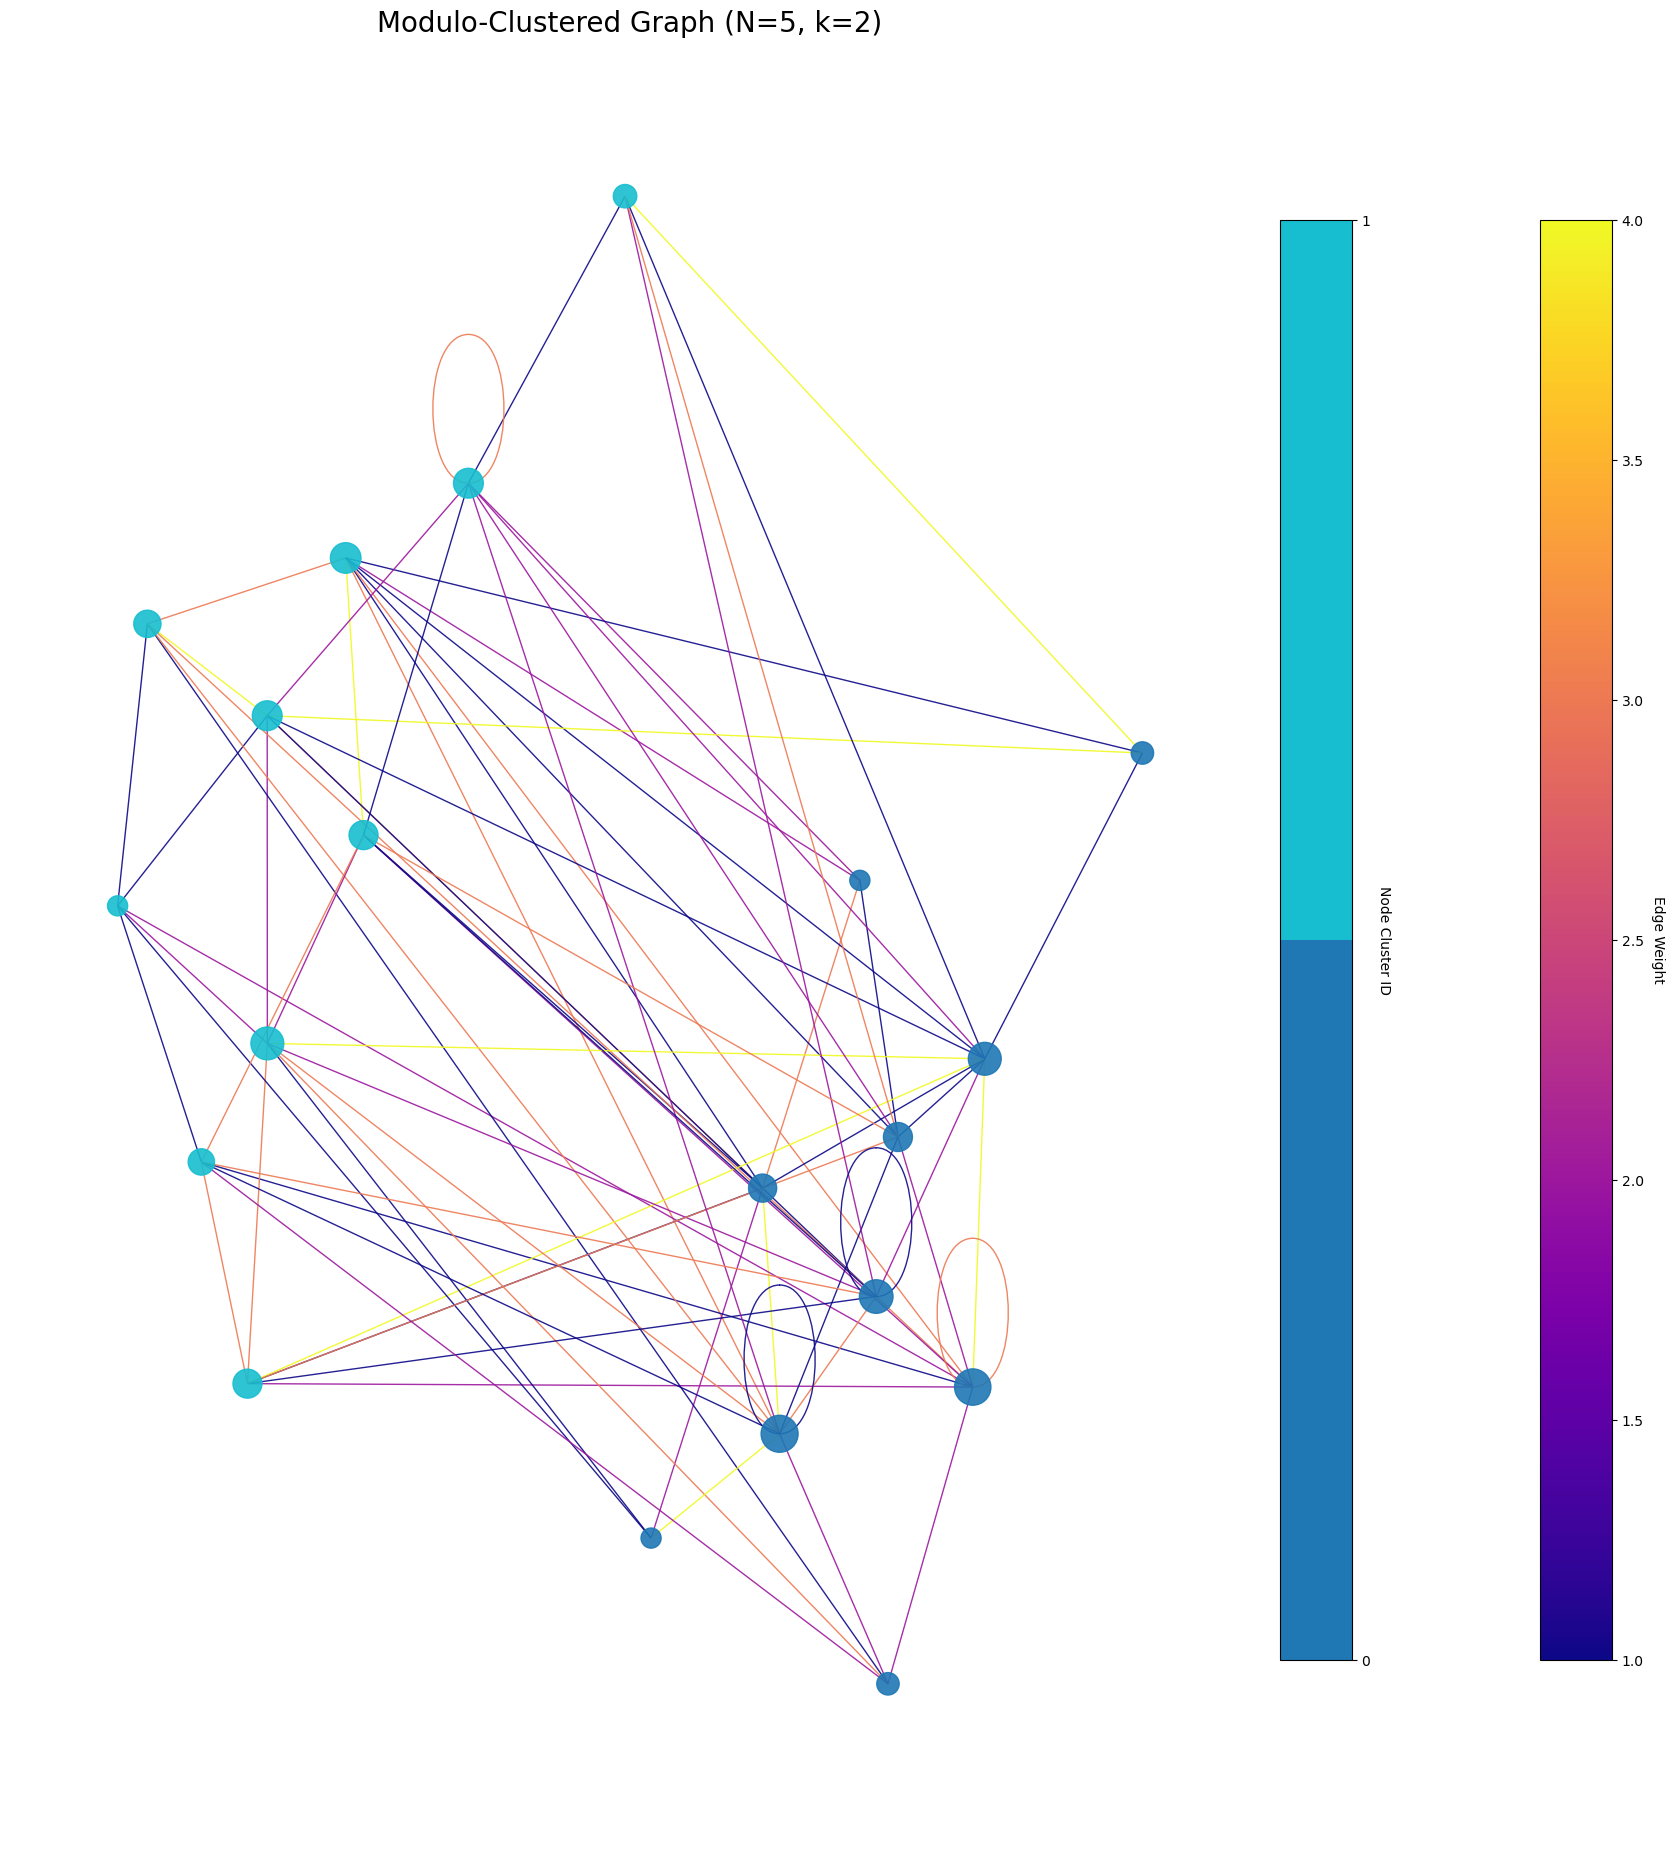

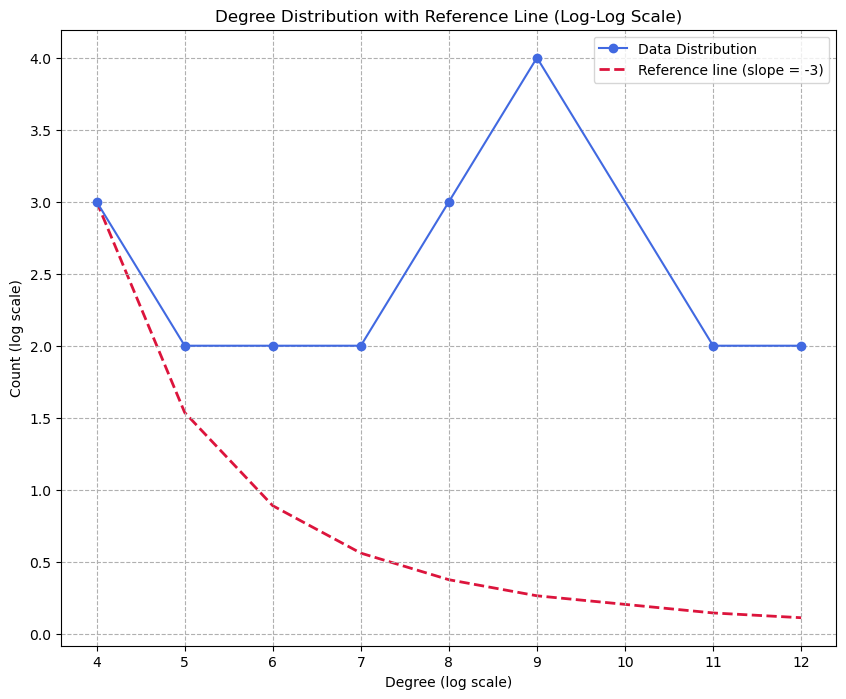

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def visualize_clustered_graph_from_matrix(
    matrix: np.ndarray, 
    num_clusters: int, 
    title: str = "Clustered Graph from Matrix"
):
    """
    N x N NumPy 행렬을 기반으로, Modulo 연산으로 클러스터링하여 그래프를 시각화합니다.

    - 클러스터 ID는 '노드 ID % num_clusters'로 결정됩니다.
    - 노드 색상은 클러스터 ID를 나타냅니다.
    - 같은 클러스터 노드끼리는 가깝게, 다른 클러스터는 멀게 배치됩니다.

    Args:
        matrix (np.ndarray): 시각화할 N x N 크기의 행렬.
        num_clusters (int): 나눌 클러스터의 개수 (k).
        title (str): 그래프의 제목.
    """
    graph = nx.from_numpy_array(matrix)
    cluster_map = {node: node % num_clusters for node in graph.nodes()}
    
    for u, v in graph.edges():
        if cluster_map[u] == cluster_map[v]:
            graph.edges[u, v]['layout_weight'] = 5.0 # 내부 연결
        else:
            graph.edges[u, v]['layout_weight'] = 0.1 # 외부 연결

    # 노드 크기 (이전과 동일: 가중치 차수 기준)
    degrees = dict(graph.degree(weight='weight'))
    node_sizes = [degrees.get(node, 1) * 25 + 10 for node in graph.nodes()]

    # 엣지 색상 (이전과 동일: 엣지 가중치 기준)
    edge_weights = list(nx.get_edge_attributes(graph, 'weight').values())

    # 3. 그래프 레이아웃 계산 ('layout_weight' 사용)
    plt.figure(figsize=(18, 18))
    pos = nx.spring_layout(
        graph,
        seed=42,
        k=0.8,
        iterations=100,
        weight='layout_weight' # 클러스터링에 맞춰 조정한 가중치 사용
    )

    # 4. 노드 색상 설정 (클러스터 ID 기준)
    node_colors = [cluster_map[node] for node in graph.nodes()]
    # 클러스터 구분에 적합한 컬러맵 사용 (예: 'tab10', 'Paired')
    node_cmap = plt.cm.get_cmap('tab10', num_clusters)

    # --- 시각화 ---
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=node_cmap,
        edge_color=edge_weights,
        edge_cmap=plt.cm.plasma,
        width=1.0,
        alpha=0.9
    )

    plt.title(title, size=20)
    
    # 엣지 컬러바 (이전과 동일)
    sm_edge = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
    sm_edge.set_array([])
    cbar_edge = plt.colorbar(sm_edge, ax=plt.gca(), shrink=0.8, pad=0.02)
    cbar_edge.set_label('Edge Weight', rotation=270, labelpad=15)
    
    # 5. 노드 컬러바 수정 (클러스터 ID 기준)
    sm_node = plt.cm.ScalarMappable(cmap=node_cmap, norm=plt.Normalize(vmin=0, vmax=num_clusters - 1))
    sm_node.set_array([])
    ticks = np.arange(0, num_clusters)
    cbar_node = plt.colorbar(sm_node, ax=plt.gca(), ticks=ticks, shrink=0.8, pad=0.02)
    cbar_node.set_label('Node Cluster ID', rotation=270, labelpad=15)

    plt.show()

# --- 사용 예시 ---
if __name__ == '__main__':

    matrix = np.array(datasets).T.reshape([M, M, -1]).T[1]
    clustered_graph = nx.from_numpy_array(matrix)
    # 함수 호출
    visualize_clustered_graph_from_matrix(
        matrix,
        num_clusters=k,
        title=f"Modulo-Clustered Graph (N={N}, k={k})"
    )


    degrees = [clustered_graph.degree(n) for n in clustered_graph.nodes()]

    degree_counts = collections.Counter(degrees)
    deg, cnt = zip(*sorted(degree_counts.items()))

    plt.figure(figsize=(10, 8))
    plt.plot(deg, cnt, 'o-', color='royalblue', label='Data Distribution', markersize=6, zorder=2)

    C = cnt[0] * (deg[0] ** 3) 
    ref_y = C * (np.array(deg, dtype=float) ** -3)

    plt.plot(deg, ref_y, '--', color='crimson', label='Reference line (slope = -3)', linewidth=2, zorder=1)

    # 그래프 제목 및 라벨 설정
    plt.title("Degree Distribution with Reference Line (Log-Log Scale)")
    plt.ylabel("Count (log scale)")
    plt.xlabel("Degree (log scale)")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

In [42]:
np.array(datasets).T.reshape([M, M, -1]).T[0]

array([[0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
       [1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 1, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 4, 3, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 1, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
       [0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 2, 0, 0],
       [0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 4, 0, 0, 4, 0, 0, 3, 0],
       [0, 4, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3],
       [0, 0, 1, 0, 0, 0, 3, 0, 0,

In [ ]:
from networkx.algorithms.community import modularity

communities = [set() for _ in range(k)]
for node, cluster_id in cluster_map.items():
    communities[cluster_id].add(node)

mod = modularity(clustered_graph, communities)
print(f"모듈성 (Modularity): {mod:.4f}")
print(mod >= 0.35)

10